In [1]:
import numpy as np
import os
import yaml
import pickle
import csv
import matplotlib
import h5py
import json

import torch
from torch.utils.data import DataLoader
import numpy as np # 1.19.0
import matplotlib.ticker as ticker
import torchvision
from scipy import stats
import matplotlib.patches as mpatches
from functools import partial
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import scipy
from tqdm import tqdm_notebook as tqdm
from pesummary.gw.file.strain import StrainData
import bilby
import pandas as pd
from pprint import pprint

# os.environ['MPLCONFIGDIR'] = '/home/local/nihargupte'
import dingo.gw.dataset.generate_dataset 
from dingo.gw.dataset import WaveformDataset
import dingo.gw.training.train_builders
from dingo.gw.ASD_dataset.noise_dataset import ASDDataset
from dingo.gw.waveform_generator import WaveformGenerator, sum_contributions_m
from dingo.gw.domains import build_domain, build_domain_from_model_metadata
import dingo.gw.inference
from dingo.gw.gwutils import get_window_factor
from dingo.gw.transforms import *
from dingo.core.models import PosteriorModel
from dingo.gw.inference import injection
from dingo.gw.inference.gw_samplers import GWSamplerGNPE, GWSampler


%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/nihargupte/projects/dingo-devel/tgr_venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
charizard_hex = ('#cd5241', '#084152', '#eede7b', '#207394', '#eeb45a', '#e64110', '#ff524a', '#f6a410', '#08398b', '#626262', '#833118')
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=charizard_hex)

domega220 = np.loadtxt("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/datasets/posteriors/gwtc-3-paper/GW150914/rin_GW150914_pseobnrv4hm_domega_220.dat.gz")
dtau220 = np.loadtxt("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/datasets/posteriors/gwtc-3-paper/GW150914/rin_GW150914_pseobnrv4hm_dtau_220.dat.gz")
tgr_results_150914 = pd.DataFrame(data=np.stack([domega220, dtau220]).T, columns=["domega220", "dtau220"])
tgr_results_150914.shape

(44052, 2)

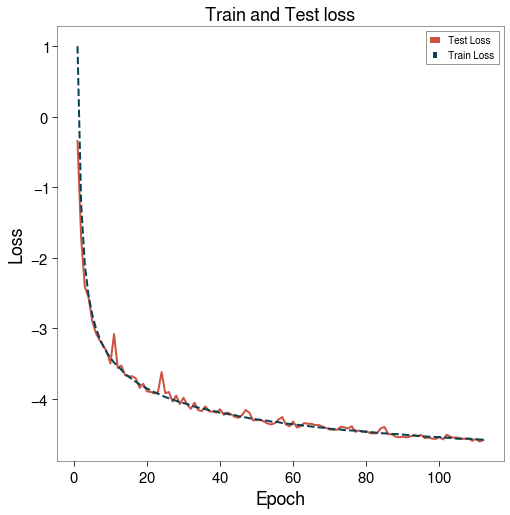

In [3]:
df = pd.read_csv("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048_marg_gnpe_high_dist/history.txt", delimiter='\t', header=None)
df.columns = ['epoch', 'train_loss', 'test_loss', '*learning_rates']
plt.figure(figsize=(8, 8))
plt.title('Train and Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df['epoch'], df['test_loss'], label='Test Loss', linewidth=2)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', linestyle='--', linewidth=2)
plt.grid()
plt.legend()


In [4]:
torch.cuda.set_device(0)

# build posterior model
main_pm = PosteriorModel(
    device="cuda",
    **{"model_filename": "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048/model_latest.pt"},
    load_training_info=False
)

time_pm = PosteriorModel(
    device='cuda',
    **{"model_filename": "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048_time/model_latest.pt"},
    load_training_info=False
)

Putting posterior model to device cuda.
Putting posterior model to device cuda.


Injections
----------

In [5]:
# Generating an injection for the network to do inference on
injection_generator = injection.Injection.from_posterior_model_metadata(main_pm.metadata)

# Opening up a asd
asd_dataset = ASDDataset(file_name= "/data/nihargupte/datasets/ASDs/2048_1/asds_O1.hdf5")
asd = asd_dataset.sample_random_asds()
injection_generator.asd = asd
injection_generator.whiten = False

# mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(1, 90)
# chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1, mass_2)
# print(chirp_mass)

intrinsic_parameters = {
    # intrinsic parameters
    "chirp_mass": 30.5,
    "mass_ratio": 0.3,
    "chi_1": -0.23,
    "chi_2": 0.2,
    "domega220": 0,
    "dtau220": 0, 
}

extrinsic_parameters = {
    'phase': 0,
    'theta_jn': 0.86,
    'geocent_time': -0.097,
    'luminosity_distance': 450,
    'ra': 0.41,
    'dec': -0.44,
    'psi': 1.19,
}

theta = {**intrinsic_parameters, **extrinsic_parameters}

# Investigate injection class
# Backwards compatability
main_pm.metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 
domain = build_domain_from_model_metadata(main_pm.metadata)
strain_data = injection_generator.injection(theta)

# Alternateivly can open up strain data from external source like if you did a Bilby run or something
# with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/bilby/injection_1/strain_data.pkl", "rb") as f:
#     strain_data = pickle.load(f)

# # Also open up the Bilby file 
# with open("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/bilby/injection_1/outdir/label_resume.pickle", "rb") as f:
#     bilby_sampler = pickle.load(f)

Setting spin_conversion_phase = None. Using phase parameter for conversion to cartesian spins.

Loading dataset from /data/nihargupte/datasets/ASDs/2048_1/asds_O1.hdf5.


In [6]:
theta = strain_data["parameters"].copy()
init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)
sampler.context = strain_data
# sampler.run_sampler(
#     num_samples=50_000,
#     batch_size=10_000,
# )
# total_mass = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_total_mass(sampler.samples["chirp_mass"], sampler.samples["mass_ratio"])
# mass_1, mass_2 = bilby.gw.conversion.total_mass_and_mass_ratio_to_component_masses(sampler.samples["mass_ratio"], total_mass)
# sampler.samples["mass_1"] = mass_1
# sampler.samples["mass_2"] = mass_2

GNPE parameters:  ['H1_time', 'L1_time']


In [ ]:
labels = ["domega220", "dtau220"]#, "chirp_mass", "mass_ratio", "chi_1", "chi_2"]

N = 1
c = ChainConsumer()
c.add_chain(sampler.samples[labels], color=charizard_hex[0], name='dingo')
# c.add_chain(bilby_sampler.samples[labels], color=charizard_hex[0], name='bilby')

c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    kde=0.7
)

fig = c.plotter.plot(truth=theta)# , filename=f'/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/SEOBNRv4HM_PA_injection_4.png')
ax = fig.axes[2]
# ax.scatter(bilby_sampler.samples["domega220"].to_numpy(), bilby_sampler.samples["dtau220"].to_numpy())
ax.legend()

GW150914 analysis
-----------------

In [ ]:
!python /data/nihargupte/projects/dingo-devel/dingo/gw/inference/inference_pipeline.py --out_directory /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_3 --model /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048/model_latest.pt --model_init /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/train_dir_SEOBNRv4HM_PA_O1_2048_time/model_latest.pt --gps_time_event 1126259462.391 --batch_size 5000

In [ ]:
!python /data/nihargupte/projects/dingo-devel/dingo/gw/importance_sampling/importance_weights.py --settings /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_3/is/is_settings.yaml --outdir /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_3/is

In [ ]:
filename = "/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/GW150914_3/dingo_samples_gps-1126259462.391.hdf5"

with h5py.File(filename, "r") as f:
    # Get the data
    dingo_samples = np.array(f["samples"])

dingo_samples = pd.DataFrame({k:np.array([d[i] for d in dingo_samples]) for i, k in enumerate(main_pm.metadata["train_settings"]["data"]["inference_parameters"])})

Loading LAL Inference Data
--------------------------

In [5]:
# Opening up lalinference data
# lalinference_samples = pd.read_csv("/home/nihargupte.HYPATIA/runs/misc/posterior_samples.dat", sep=r"\t") #GW150914_2/cbcBayes/posterior_samples.dat", sep=r"\t")
lalinference_samples = pd.read_csv("/home/nihargupte.HYPATIA/runs/GW150914_2/cbcBayes/posterior_samples.dat", sep=r"\t")
lalinference_samples_2 = pd.read_csv("/home/nihargupte.HYPATIA/runs/GW150914_4/cbcBayes/posterior_samples.dat", sep=r"\t")
print(lalinference_samples.shape, lalinference_samples_2.shape)
lalinference_samples = pd.concat([lalinference_samples, lalinference_samples_2])

/tmp/ipykernel_3007107/3456391520.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  lalinference_samples = pd.read_csv("/home/nihargupte.HYPATIA/runs/GW150914_2/cbcBayes/posterior_samples.dat", sep=r"\t")
/tmp/ipykernel_3007107/3456391520.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  lalinference_samples_2 = pd.read_csv("/home/nihargupte.HYPATIA/runs/GW150914_4/cbcBayes/posterior_samples.dat", sep=r"\t")


(6565, 78) (4423, 78)


In [6]:
# Loading the data that we got from the LALInference run instead of just specifying the GPS time
from gwpy.timeseries import TimeSeries
from lalframe.frread import read_timeseries
lalinference_psd_H1 = np.genfromtxt("/home/nihargupte.HYPATIA/runs/GW150914_2/engine/lalinferencemcmc-0-H1L1-1126259462.391-1.hdf5H1-PSD.dat")
lalinference_psd_L1 = np.genfromtxt("/home/nihargupte.HYPATIA/runs/GW150914_2/engine/lalinferencemcmc-0-H1L1-1126259462.391-1.hdf5L1-PSD.dat")
# Copied directly from LALinference run except had to move where the file was since saraswati can't access HYPATIA localhost

# source = "/home/nihargupte.HYPATIA/data/frame_files/GW150914/L-L1_HOFT_C02_CACHE-1126259184-297.lcf"
# source = lal.CacheImport(os.path.expanduser(source))
# print(dir(source))
# L1_data = read_timeseries(source=source, channel="L1:DCS-CALIB_STRAIN_C02")
lalinference_strain_data_L1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/L-L1_HOFT_C02-1126256640-4096.gwf", "L1:DCS-CALIB_STRAIN_C02")
lalinference_strain_data_H1 = TimeSeries.read("/home/nihargupte.HYPATIA/data/frame_files/GW150914/H-H1_HOFT_C02-1126256640-4096.gwf", "H1:DCS-CALIB_STRAIN_C02")
lal_strain = {"H1": lalinference_strain_data_H1, "L1": lalinference_strain_data_L1}

# Trimming to match our event time and buffer time
from dingo.gw.inference.data_preparation import data_to_domain, get_event_data_and_domain, parse_settings_for_raw_data, load_raw_data
time_psd = 1024
time_buffer = 2.0
time_event = 1126259462.391

# lalinference_strain_data_L1.plot()
settings_raw_data = parse_settings_for_raw_data(main_pm.metadata, time_psd, time_buffer)
start_time = time_event + time_buffer - settings_raw_data["time_segment"]
end_time = time_event + time_buffer
print(start_time, end_time)

# Resampling to 4096, note this applies some windowing so I'm not entirely sure of the results
for ifo_name, strain in lal_strain.items():
    strain = strain.resample(rate=4096)
    slice_idxs = [np.argmin(np.abs(np.array(strain.times) - start_time)), np.argmin(np.abs(np.array(strain.times) - end_time))]
    trimmed_strain = strain[slice_idxs[0]:slice_idxs[1]]
    lal_strain[ifo_name] = trimmed_strain

init_sampler = GWSampler(model=time_pm)
sampler = GWSamplerGNPE(model=main_pm, init_sampler=init_sampler, num_iterations=30)

1126259456.391 1126259464.391
GNPE parameters:  ['H1_time', 'L1_time']


In [9]:
# raw_data = load_raw_data(1126259462.391, settings=settings_raw_data)
raw_data = {
    "strain":None,
    "psd": {"H1": None, "L1": None}
}
raw_data["strain"] = lal_strain
raw_data["psd"]["H1"] = lalinference_psd_H1[:, 1]
raw_data["psd"]["L1"] = lalinference_psd_L1[:, 1]


# step 2: prepare the data for the network domain
domain = build_domain_from_model_metadata(main_pm.metadata)
event_data = data_to_domain(
    raw_data,
    settings_raw_data,
    domain,
    window=main_pm.metadata["train_settings"]["data"]["window"],
)
sampler.context = event_data
sampler.event_metadata = {
    "time_event": time_event,
    "time_psd": time_psd,
    "time_buffer": time_buffer,
}

Importance Sampling Old Way
---------------------------

In [ ]:
import warnings

# warnings.filterwarnings(
#     "ignore"
# )  # [W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool) don't worry about this message it is
# A known issue with pytorch that is fixed in the nightly
nde_settings = {
    "synthetic_phase": {
        "approximation_22_mode": False,
        "n_grid": 5001, 
        "uniform_weight": 0.01,
        "num_processes": 10,
    },
    "model": {
        "type": "nsf",
        "num_flow_steps": 8,
        "base_transform_kwargs": {
            "hidden_dim": 128,
            "num_transform_blocks": 10,
            "activation": "elu",
            "dropout_probability": 0.1,
            "batch_norm": True,
            "num_bins": 8,
            "base_transform_type": "rq-coupling",
        },
    },
    "training": {
        "device": "cuda",
        "num_workers": 0,
        "train_fraction": 0.9,
        "batch_size": 4096,
        "epochs": 20,
        "optimizer": {"type": "adam", "lr": 0.003},
        "scheduler": {"type": "cosine", "T_max": 20},
    },
}
sampler.prepare_log_prob(
    num_samples=50_000, batch_size=5_000, nde_settings=nde_settings
)

In [ ]:
sampler.gnpe_proxy_sampler.run_sampler(num_samples=50_000, batch_size=5_000)
N = 1
c = ChainConsumer()
c.add_chain(sampler.gnpe_proxy_sampler.samples[["H1_time_proxy", "L1_time_proxy"]], color=charizard_hex[0], name='dingo')#, weights=weights) #, weights=sampler.samples["weights"])
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [.50, .90]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    # color_params="weights",
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7,
)
c.plotter.plot()

In [ ]:
# Importance sampling 
sampler.context = event_data
sampler.run_sampler(num_samples=50_000, batch_size=5_000)
sampler.importance_sample()

Importance Sampling + Synethetic Phase
======================================

In [10]:
# Importance sampling 
sampler.context = event_data
sampler.run_sampler(num_samples=5_000, batch_size=5_000)
sampler.samples = sampler.samples.drop(columns=[param for param in sampler.samples.columns  if "GNPE:" in param])
#sampler.samples = sampler.samples.drop(columns=[param for param in sampler.samples.columns  if "GNPE:" in param or "phase"==param])
# Throw away phase because of synthetic phase NOTE should we really be marginalizing over this or is dropping it have the same effect
#sampler.metadata["train_settings"]["data"]["inference_parameters"].remove("phase")
# sampler.samples.drop(columns=["phase"])
sampler.base_model_metadata["dataset_settings"]["waveform_generator"]["spin_conversion_phase"] = 0 
outdir = "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_8/is"
sampler.to_hdf5(label="training_samples", outdir=outdir)

Running sampler to generate 5000 samples.
it 0.	proxy mean:  0.03486 0.02786 	proxy std: 0.00131 0.00135
it 1.	proxy mean:  0.03465 0.02762 	proxy std: 0.00123 0.00125
it 2.	proxy mean:  0.03445 0.02741 	proxy std: 0.00115 0.00118
it 3.	proxy mean:  0.03430 0.02728 	proxy std: 0.00108 0.00110
it 4.	proxy mean:  0.03420 0.02718 	proxy std: 0.00102 0.00104
it 5.	proxy mean:  0.03412 0.02709 	proxy std: 0.00097 0.00098
it 6.	proxy mean:  0.03407 0.02703 	proxy std: 0.00092 0.00093
it 7.	proxy mean:  0.03402 0.02698 	proxy std: 0.00089 0.00090
it 8.	proxy mean:  0.03402 0.02697 	proxy std: 0.00086 0.00086
it 9.	proxy mean:  0.03399 0.02695 	proxy std: 0.00083 0.00083
it 10.	proxy mean:  0.03396 0.02691 	proxy std: 0.00080 0.00082
it 11.	proxy mean:  0.03396 0.02690 	proxy std: 0.00078 0.00080
it 12.	proxy mean:  0.03395 0.02690 	proxy std: 0.00080 0.00078
it 13.	proxy mean:  0.03395 0.02688 	proxy std: 0.00077 0.00079
it 14.	proxy mean:  0.03394 0.02689 	proxy std: 0.00076 0.00077
it 15.	p

In [12]:
from dingo.core.samples_dataset import SamplesDataset
from dingo.gw.importance_sampling.importance_weights import importance_sample

sampler.metadata["event"] = {}
sampler.metadata["event"]["time_event"] = 1126259462.391
samples_dataset = SamplesDataset(
    dictionary={
        "samples": sampler.samples,
        "context": event_data,
        "settings": sampler.metadata,
    }
)
settings = {
    "num_samples": 1_000,
    "num_processes": 16,
    "slice_plots": {
        "num_slice_plots": 0,
        "params_slice2d": [["phase", "geocent_time"], ["phase", "chi_1"]],
    },
    "synthetic_phase": {
        "approximation_22_mode": False,
        "n_grid": 5001,
        "uniform_weight": 0.01,
        "num_processes": 1,
    },
    "nde": {
        "data": {"parameters": list(sampler.samples.columns)},
        "model": {
            "type": "nsf",
            "num_flow_steps": 8,
            "base_transform_kwargs": {
                "hidden_dim": 128,
                "num_transform_blocks": 10,
                "activation": "elu",
                "dropout_probability": 0.1,
                "batch_norm": True,
                "num_bins": 8,
                "base_transform_type": "rq-coupling",
            },
        },
        "training": {
            "device": "cuda",
            "num_workers": 0,
            "train_fraction": 0.9,
            "batch_size": 4096,
            "epochs": 20,
            "optimizer": {"type": "adam", "lr": 0.000835},
            "scheduler": {"type": "cosine", "T_max": 20},
        },
    },
}
importance_sample(settings, samples_dataset, outdir)

Loading nde at /data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_7/is/nde-1126259462.391.pt for event 1126259462.391.
Putting posterior model to device cuda.
Generating 1000 samples from proposal distribution.
Running sampler to generate 1000 samples.


AssertionError: Expected 12 parameters (['chirp_mass', 'mass_ratio', 'chi_1', 'chi_2', 'theta_jn', 'dec', 'ra', 'geocent_time', 'luminosity_distance', 'psi', 'domega220', 'dtau220']), but got 13.

In [10]:
from dingo.gw.inference.gw_samplers import GWSamplerUnconditional
from dingo.core.samples_dataset import SamplesDataset
labels = main_pm.metadata["train_settings"]["data"]["inference_parameters"].copy()
labels.append("weights")
print(labels)
# nde_pm = PosteriorModel(
#     device='cuda',
#     **{"model_filename": "/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_3/is/nde-1126259462.391.pt"},
#     load_training_info=False
# )
# nde_sampler = GWSamplerUnconditional(model=nde_pm)

with h5py.File("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_6/is/dingo_samples_weighted.hdf5", "r") as f:
    a = f["samples"].fields(labels)[:]
    arr = np.empty((a.shape[0], len(labels)))
    for i in range(a.shape[0]):
        arr[i, :] = list(a[i])
weighted_dingo_samples = pd.DataFrame(arr, columns=labels)
threshold = 1e-3
inds = np.where(weighted_dingo_samples["weights"] > threshold)[0]
# Would have liked to just load the hdf5 file with samples dataset but getting weird syntax error
# weighted_samples = SamplesDataset(file_name="/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/dumps/GW150914_5/is/dingo_samples_weighted.hdf5")
# nde_sampler = GWSamplerUnconditional(samples_dataset=weighted_samples)

['chirp_mass', 'mass_ratio', 'phase', 'chi_1', 'chi_2', 'theta_jn', 'dec', 'ra', 'geocent_time', 'luminosity_distance', 'psi', 'domega220', 'dtau220', 'weights']


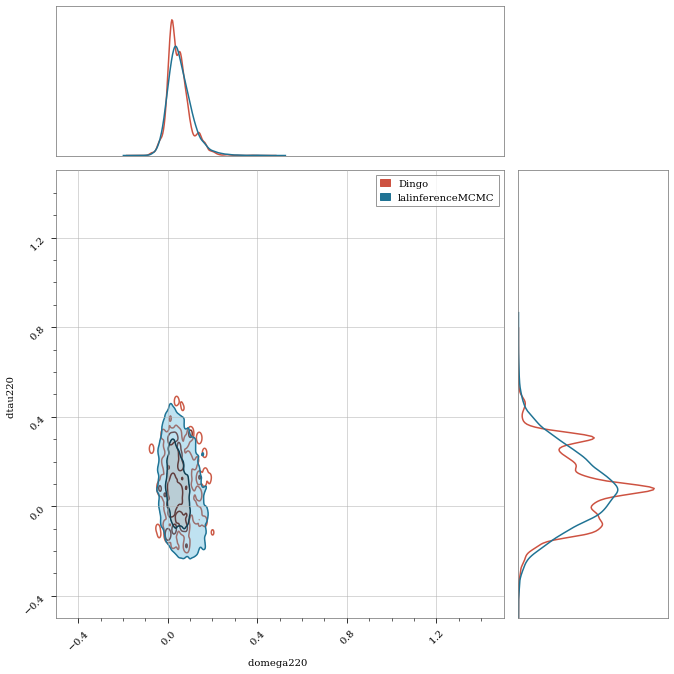

In [11]:
N = 2
c = ChainConsumer()
c.add_chain(weighted_dingo_samples[["domega220", "dtau220"]], color=charizard_hex[0], name='dingo', weights=weighted_dingo_samples["weights"])
# c.add_chain(dingo_kde_samples[["domega220", "dtau220"]], color=charizard_hex[4], name='dingo kde')
c.add_chain(lalinference_samples[["domega220", "dtau220"]], color=charizard_hex[3], name='lalinferenceMCMC', weights=None)
# c.add_chain(tgr_results_150914[["domega220", "dtau220"]], color='k', name='tgr paper')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [.50, .90]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    # color_params="weights",
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    kde=0.7,
)

fig = c.plotter.plot(extents={"domega220":(-0.5, 1.5), "dtau220":(-0.5, 1.5)})
fig.set_size_inches(10, 10)
ax = fig.axes[2]
ax.minorticks_on()  
# ax.scatter(dingo_kde_samples["domega220"], dingo_kde_samples["dtau220"], color=charizard_hex[4], s=1)
# ax.scatter(lalinference_samples["domega220"], lalinference_samples["dtau220"], color=charizard_hex[3], s=1)
# ax.plot(tgr_paper_150914["df220"], tgr_paper_150914["dtau220"], c='k', label="from TGR paper")
ax.legend()

dingo_patch = mpatches.Patch(color=charizard_hex[0], label='Dingo')
# paper_patch = mpatches.Patch(color='k', label="from TGR paper")
lalmcmc_patch = mpatches.Patch(color=charizard_hex[3], label="lalinferenceMCMC")
ax.legend(handles=[dingo_patch, lalmcmc_patch])
# fig.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/TGR_comparison_2048_weighted.png")

In [12]:
lalinference_samples["mass_ratio"] = bilby.gw.conversion.component_masses_to_mass_ratio(lalinference_samples["m1"], lalinference_samples["m2"])
lalinference_samples["chirp_mass"] = bilby.gw.conversion.component_masses_to_chirp_mass(lalinference_samples["m1"], lalinference_samples["m2"])
lalinference_samples = lalinference_samples.rename(columns={"dist":"luminosity_distance", "time":"geocent_time", "a1z":"chi_1", "a2z":"chi_2"})
# Entire Corner Plot
N = 2
c = ChainConsumer()
c.add_chain(lalinference_samples[main_pm.metadata["train_settings"]["data"]["inference_parameters"]], color=charizard_hex[3], name='lalinference_mcmc')
c.add_chain(weighted_dingo_samples[main_pm.metadata["train_settings"]["data"]["inference_parameters"]], color=charizard_hex[0], name='dingo', weights=weighted_dingo_samples["weights"])
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [0.5, 0.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

c.plotter.plot()
plt.savefig("/data/nihargupte/projects/dingo-devel/tutorials/06_tgr/plots/full_PE_weighted.png")

PP Plot
-------

/tmp/ipykernel_1427902/87147839.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm(range(neval)):


  0%|          | 0/1000 [00:00<?, ?it/s]

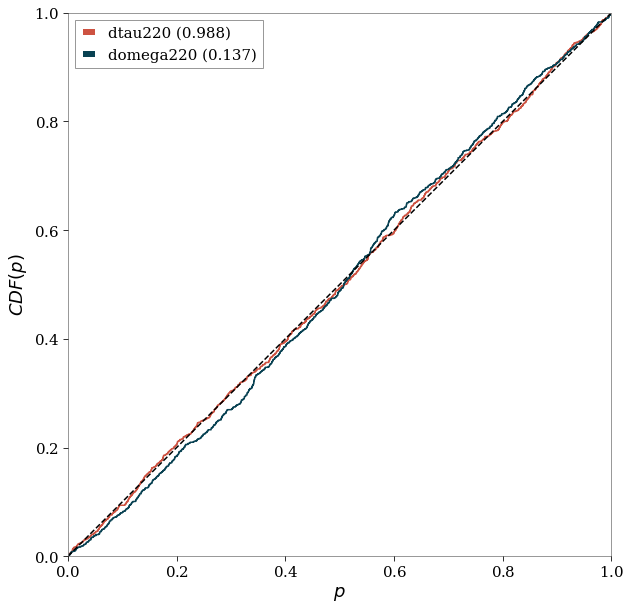

In [29]:
def make_pp(percentiles, parameter_labels, ks=True):

    percentiles = percentiles / 100.0
    nparams = percentiles.shape[-1]
    nposteriors = percentiles.shape[0]

    ordered = np.sort(percentiles, axis=0)
    ordered = np.concatenate((np.zeros((1, nparams)), ordered, np.ones((1, nparams))))
    y = np.linspace(0, 1, nposteriors + 2)

    fig = plt.figure(figsize=(10, 10))

    for n in range(nparams):
        if ks:
            pvalue = stats.kstest(percentiles[:, n], "uniform")[1]
            plt.step(
                ordered[:, n],
                y,
                where="post",
                label=parameter_labels[n] + r" ({:.3g})".format(pvalue),
            )
        else:
            plt.step(ordered[:, n], y, where="post", label=parameter_labels[n])
    plt.plot(y, y, "k--")
    plt.legend(prop={"size": 15})
    plt.ylabel(r"$CDF(p)$")
    plt.xlim((0, 1))
    plt.ylim((0, 1))

    plt.xlabel(r"$p$")

    ax = fig.gca()
    ax.set_aspect("equal", anchor="SW")

    plt.grid()
    plt.show()

labels = ['dtau220', 'domega220']
neval = 1000  # number of injections
nparams = len(labels)

percentiles = np.empty((neval, nparams))
for idx in tqdm(range(neval)):
    strain_data = injection_generator.random_injection()
    sampler.context = strain_data.copy()
    sampler.run_sampler(
        num_samples=25_000,
        batch_size=25_000,
    )
    pred = np.stack([sampler.samples[l] for l in labels])
    actual = np.array([strain_data["parameters"][l] for l in labels])

    for n in range(nparams):
        percentiles[idx, n] = stats.percentileofscore(pred[n, :], actual[n])

make_pp(percentiles, labels)

Combining Data From Multiple Injections
---------------------------------------

[0.1342990578748799, 0.23817338182515863]


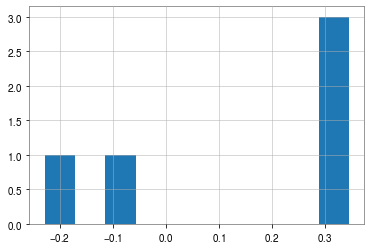

In [7]:
# Simulate data that is drawn from a gaussian distribution, see if we can recove the "hyperposterior"
n_data_points = 5
injection_parameters = injection_generator.prior.sample(n_data_points)
# So our injection phi is 0, .3
true_phi = [0, .3]
dtau220_injection_values = np.random.normal(loc=true_phi[0], scale=true_phi[1], size=n_data_points)
injection_parameters["dtau220"] = dtau220_injection_values
injection_parameters = [{k:v[i] for k, v in injection_parameters.items()} for i in range(injection_parameters["chirp_mass"].shape[0])]
data = [injection_generator.injection(parameters) for parameters in injection_parameters]
plt.hist([a["dtau220"] for a in injection_parameters])
true_sample_phi = [np.mean(dtau220_injection_values), np.std(dtau220_injection_values)]
print(true_sample_phi)

In [8]:
# Generating posteriors for the injections
posteriors = {}
for k, v in enumerate(data):
    sampler.context = v
    sampler.run_sampler(num_samples=50_000,batch_size=10_000)
    posteriors[k] = sampler.samples[["dtau220", "domega220"]]
posteriors = {k:np.array([posterior[k].to_numpy() for posterior in posteriors.values()]) for k in posteriors[0].columns}

In [ ]:
# Code developed by Max Isi:
def fit_it(chi_samples, nobs, nsamp, model, niter=2000):
    ''' Carry out Stan population fit for a given parameter ("chi").
    
    Arguments
    ---------
    chi_samples: array
        samples for all events `[[event_1_samples], [event_2_samples] ...]`
    nobs: int
        number of events (i.e. observations).
    nsamp: int
        number of samples per event (subselects for speed).
    model: pystan.StanModel
        stan model.
    niter: int
        number of stan iterations (def. 2000).
    '''
    #samples = [cs[:nsamp] for cs in chi_samples[:nobs]]
    chosen_chi_samples = chi_samples[np.random.choice(range(len(chi_samples)),
                                                      nobs, replace=False)]
    samples = []
    for cs in chosen_chi_samples:
        idxs = np.random.choice(range(len(cs)), nsamp, replace=False)
        samples.append(cs[idxs])
    stan_data = {'nobs': nobs, 'nsamp': nsamp, 'chis': samples}
    return model.sampling(data=stan_data, iter=niter)

def fit_all(data, fits=None, max_nsamples=1000,
            scale_factors=None, **kwargs):
    ''' Fit a series of parameters, if fit not already in `fits`.
    
    Arguments
    ---------
    data: dict
        dictionary with individual-event samples for each parameter.
    fits: dict
        dictionary with population fit results.
    cache: str
        path template to cache fit results.
    max_nsamples: int
        maximum number of individual-event samples used in population fit.
    scale_factors: dict
        optionally scale parameters (x -> x/scale) to bring it into unit
        range; the keys must be names of parameters to rescale. (The scaling
        is undone before returning the result.)
        
    Returns
    -------
    fits: dict
        dictionary with fit results.
    '''
    if fits is None:
        fits = {}
    if scale_factors is None:
        scale_factors = {k: 1 for k in data.keys()}
    failed = []
    for label, chi_samples_dict in data.items():
        if label not in fits:
            chi_samples = np.array(list(chi_samples_dict.values()))
            # rescale samples by some scalar to ease sampling
            sf = scale_factors.get(label, 1.0)
            chi_samples /= sf
            # number of observations (events)
            no = len(chi_samples_dict)
            # number of posterior samples
            nsamples = [len(s) for s in chi_samples]
            ns = min(min(nsamples), max_nsamples)
            if no > 0:
                fit = fit_it(chi_samples, no, ns, **kwargs)
                # restore original scale to the data
                fits[label] = {k: fit[k]*sf for k in ['mu', 'sigma', 'pop']}
            else:
                print("WARNING: no data for %s" % label)
                failed.append(label)
    return fits

def save_cache(fits, cache_path, paths=None):
    for param, fit in fits.items():
        try:
            post = fit.extract(['mu', 'sigma', 'pop'])
        except AttributeError:
            post = fit
        for k in ['mu', 'sigma', 'pop']:
            np.savetxt(cache_path.format(par=param, hyper=k), post[k])
        print("Cached %s"%  param)
    # record list of events
    if paths:
        cache_dir = os.path.dirname(cache_path)
        log_path = os.path.join(cache_dir, 'events.json')
        with open(log_path, 'w') as f:
            json.dump(paths, f, indent=4)
        print("Events logged: %r" % log_path)
     

model = pystan.StanModel(file='/home/local/nihargupte/dingo-devel/tutorials/06_tgr/src/hier_gr.stan')
cache_path = "/home/local/nihargupte/dingo-devel/tutorials/06_tgr/dumps/pystan"
# Fit it! (only if needed: `fit_all` checks whether fit already exists)
# data ?= {"domega220":np.array[[event_1_samples], [event_2_samples] ...], "dtau220":[[samples1], [samples2]]}
fits = fit_all(posteriors, model=model)
save_cache(fits, cache_path)

Combining Data From Multiple Injections
---------------------------------------

[0.1595227550768951, 0.0]


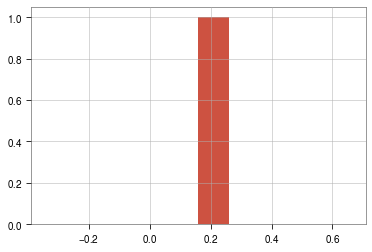

In [6]:
# Simulate data that is drawn from a gaussian distribution, see if we can recove the "hyperposterior"
n_data_points = 1
injection_parameters = injection_generator.prior.sample(n_data_points)
# So our injection phi is 0, .3
true_phi = [0, .3]
dtau220_injection_values = np.random.normal(loc=true_phi[0], scale=true_phi[1], size=n_data_points)
injection_parameters["dtau220"] = dtau220_injection_values
injection_parameters = [{k:v[i] for k, v in injection_parameters.items()} for i in range(injection_parameters["chirp_mass"].shape[0])]
data = [injection_generator.injection(parameters) for parameters in injection_parameters]
plt.hist([a["dtau220"] for a in injection_parameters])
true_sample_phi = [np.mean(dtau220_injection_values), np.std(dtau220_injection_values)]
print(true_sample_phi)

In [7]:
def get_kde(samples):
    """Given samples return the 1D kde"""
    # Generate 100_000 points and use that as a KDE
    kde = scipy.stats.gaussian_kde(samples)
    return kde

def get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
    theta_points = np.linspace(
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
    integral_granularity,
    )
    dtheta = (eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum - eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum) / integral_granularity

    unnormalized_prob_phi_given_data = 1
    gaussian = scipy.stats.norm(loc=phi[0], scale=phi[1])
    for d in data:
        sampler.context = d
        sampler.run_sampler(num_samples=10_000,batch_size=10_000)
        # Sample 
        posterior_kde = get_kde(sampler.samples[param])
        
        unnormalized_prob_d_given_phi = 0
        for theta in theta_points:
            prob_theta_given_phi = gaussian.pdf(theta)
            prob_d_given_theta = posterior_kde.pdf(theta)[0]
            unnormalized_prob_d_given_phi += prob_theta_given_phi * prob_d_given_theta * dtheta
        unnormalized_prob_phi_given_data *= unnormalized_prob_d_given_phi
    return unnormalized_prob_phi_given_data

param = "dtau220"
# Defining grid granularity
phi_grid_granularity = 5
# mu, sigma prior, these two toghether define phi
mu_prior = bilby.core.prior.Uniform(-0.5, 0.5)
sigma_prior = bilby.core.prior.Uniform(0.01, 0.7)

# Very naive approach just evaluating the integral numerically on a grid, will take forever
# Creating a grid of points according to prior on phi
mu = np.linspace(mu_prior.minimum, mu_prior.maximum, phi_grid_granularity)
dmu = (mu_prior.maximum - mu_prior.minimum) / phi_grid_granularity
sigma = np.linspace(sigma_prior.minimum, sigma_prior.maximum, phi_grid_granularity)
dsigma = (sigma_prior.maximum - sigma_prior.minimum) / phi_grid_granularity
mu, sigma = np.meshgrid(mu, sigma)
mu = mu.flatten()
sigma = sigma.flatten()

# unnormalized_prob_phi_given_data = []
# for mu_i, sigma_i in zip(mu, sigma):
#     print(mu_i, sigma_i)
#     unnormalized_prob_phi_given_data.append(get_unormalized_phi_given_data(data, sampler, param, [mu_i, sigma_i]))
# unnormalized_prob_phi_given_data = np.array(unnormalized_prob_phi_given_data)

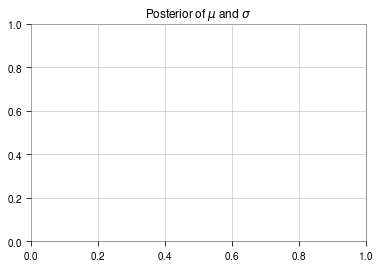

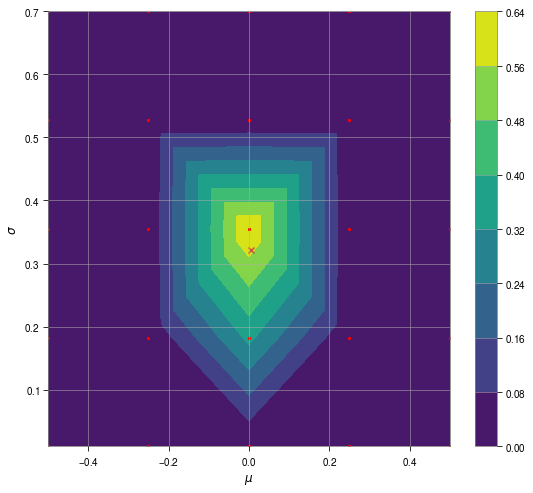

In [62]:
prob_phi_given_data = unnormalized_prob_phi_given_data / np.sum(unnormalized_prob_phi_given_data)
plt.title(r"Posterior of $\mu$ and $\sigma$")
plt.figure(figsize=(9, 8))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
ax = plt.tricontourf(mu, sigma, prob_phi_given_data)
plt.scatter(true_sample_phi[0], true_sample_phi[1], marker='x')
plt.scatter(mu, sigma, s=5, c='r')
plt.colorbar(ax)

Using PyMC to speed up computation of P(\phi | {data})

In [27]:
import dynesty

# Using dynesty to sample, tbh dynesty expects a normalized liklihood so idk how well this is gonna work, but mathematically the normalization between the posterior and 
# the liklihood should be absorbed into the overal normalization factor so in principle it should be possible
def get_log_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
    return np.log(get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity=integral_granularity))

def prior(u):
    a = 1. * (2. * u[0] - 1.)
    b = 1. * u[1]
    return np.array([a, b])

loglike = partial(get_log_unnormalized_phi_given_data, data, sampler, "dtau220")
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, prior, 2, print_progress=True)
# sampler.run_nested()
# sresults = sampler.results

Exception while calling loglikelihood function:
  params: [-0.08927524  0.7678287 ]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/local/nihargupte/tgr/venv/lib/python3.9/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2265708/1808631330.py", line 6, in get_log_unnormalized_phi_given_data
    return np.log(get_unnormalized_phi_given_data(data, sampler, param, phi, integral_granularity=integral_granularity))
  File "/tmp/ipykernel_2265708/3577302632.py", line 9, in get_unnormalized_phi_given_data
    eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
AttributeError: 'MultiEllipsoidSampler' object has no attribute 'metadata'


AttributeError: 'MultiEllipsoidSampler' object has no attribute 'metadata'

In [28]:
def metropolis_Gaussian(p, z0, std, n_samples=100, burn_in=0, m=1, prior=None):
    """
    Metropolis Algorithm using a Gaussian proposal distribution.
    p: distribution that we want to sample from (can be unnormalized)
    z0: Initial sample
    std: standard deviation of the proposal normal distribution.
    n_samples: number of final samples that we want to obtain.
    burn_in: number of initial samples to discard.
    m: this number is used to take every mth sample at the end
    """
    # Pre-allocate memory for samples (much more efficient than using append)
    samples = np.zeros(shape=(n_samples, 2))

    # Store initial value
    samples[0] = z0
    z = z0
    # Compute the current likelihood
    l_cur = p(z)

    # Counter
    iter = 0
    # Total number of iterations to make to achieve desired number of samples
    iters = (n_samples * m) + burn_in

    # Sample outside the for loop
    innov = np.random.normal(loc=0, scale=std, size=(iters, 2))
    u = np.random.rand(iters)

    while iter < iters:
        # Random walk innovation on z
        cand = z + innov[iter]
        # Compute candidate likelihood
        l_cand = p(cand)

        # Accept or reject candidate
        if l_cand / l_cur > u[iter] and check_prior(cand, prior):
            z = cand
            print(z)
            l_cur = l_cand

        # Only keep iterations after burn-in and for every m-th iteration
        if iter > burn_in and iter % m == 0:
            samples[(iter - burn_in) // m] = z

        iter += 1

    return samples

def check_prior(sample, prior):
    if prior == None:
        return True
    return np.all([sample[i] < prior[i].maximum and sample[i] > prior[i].minimum for i in range(len(prior))])

p = partial(get_unnormalized_phi_given_data, data, sampler, "dtau220")
samples = metropolis_Gaussian(p, z0=np.array([0, 0.3]), n_samples=1_000, std=.1, burn_in=100, prior=[mu_prior, sigma_prior])
    

[-0.24201113  0.10764854]
[-0.25071716  0.10563146]
[-0.16993953  0.04873866]
[-0.18920385  0.08155334]
[-0.26743612  0.14214402]
[-0.42927715  0.17814507]
[-0.33462285  0.12003599]
[-0.37811671  0.17725802]
[-0.36522464  0.2108195 ]
[-0.39302138  0.1839453 ]
[-0.21924408  0.23912015]
[-0.14492121  0.27229143]
[-0.22359132  0.30464289]
[-0.26414294  0.286814  ]
[-0.17005115  0.32431913]
[-0.03149974  0.43226486]
[-0.14785605  0.56462747]
[-0.15197316  0.5705168 ]
[-0.17889889  0.50123461]
[-0.0706202   0.51492687]
[0.02395632 0.39842711]
[0.11485452 0.31824235]
[0.1550117  0.38986162]
[0.17640109 0.49128587]
[0.22218091 0.48396225]
[0.24958852 0.60615192]
[0.27619294 0.62864894]
[0.35299719 0.58572011]
[0.40909033 0.58497675]
[0.35198685 0.6582349 ]
[0.40496502 0.62728012]
[0.47511057 0.62848707]
[0.46852847 0.65238513]
[0.42328831 0.43063797]
[0.37487741 0.243349  ]
[0.35671844 0.27382055]
[0.25577755 0.10743901]
[0.2844818 0.1457867]
[0.19375271 0.09169681]
[0.23961097 0.33508761]
[0

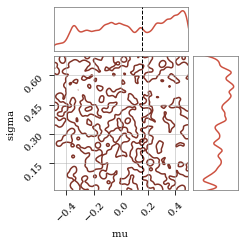

In [30]:
N = 1
c = ChainConsumer()
c.add_chain({"mu": samples[:, 0], "sigma": samples[:, 1]}, color=charizard_hex[0], name='dingo')
c.configure(
    linestyles=["-"] * N,
    linewidths=[1.5] * N,
    sigmas=[np.sqrt(2) * scipy.special.erfinv(x) for x in [.9]],
    shade=[False] + [True] * (N - 1),
    shade_alpha=0.3,
    bar_shade=False,
    label_font_size=10,
    tick_font_size=10,
    usetex=False,
    legend_kwargs={"fontsize": 30},
    # kde=0.7
)

fig = c.plotter.plot(truth={"mu":true_sample_phi[0], "sigma":true_sample_phi[1]})

In [ ]:
from bilby.core.prior import Constraint
param_keys = [k for k, v in sampler.prior.items() if not isinstance(v, Constraint)]
theta = sampler.samples[param_keys][1000:1100]
constraints = np.array([sampler.prior.evaluate_constraints(t) for _, t in theta.iterrows()])
print(constraints)
((50_000 / 100) * 1.3) / 60

In [71]:
from line_profiler import LineProfiler
lp = LineProfiler()
lp_wrapper = lp(get_unormalized_phi_given_data)
lp_wrapper(data, sampler, param, [mu_i, sigma_i])
lp.print_stats()

Timer unit: 1e-06 s

Total time: 22.088 s
File: /tmp/ipykernel_1596441/1336958928.py
Function: get_unormalized_phi_given_data at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def get_unormalized_phi_given_data(data, sampler, param, phi, integral_granularity = 100):
     8         2        180.0     90.0      0.0      theta_points = np.linspace(
     9         1         92.0     92.0      0.0      eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
    10         1         45.0     45.0      0.0      eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
    11         1          1.0      1.0      0.0      integral_granularity,
    12                                               )
    13         1         89.0     89.0      0.0      dtheta = (eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum - eval(sampler.metadata["dataset_settings"]["in

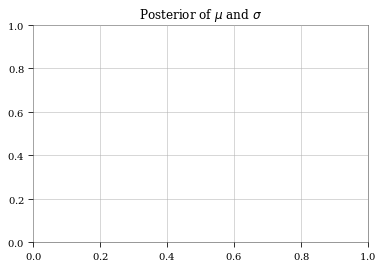

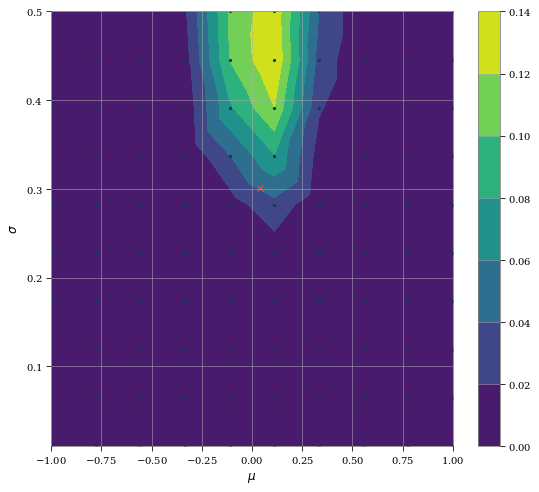

In [ ]:
prob_phi_given_data = unnormalized_prob_phi_given_data / np.sum(unnormalized_prob_phi_given_data)
plt.title(r"Posterior of $\mu$ and $\sigma$")
plt.figure(figsize=(9, 8))
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma$")
ax = plt.tricontourf(mu, sigma, prob_phi_given_data)
plt.scatter(true_sample_phi[0], true_sample_phi[1], marker='x')
plt.scatter(mu, sigma, s=5)
plt.colorbar(ax)
plt.savefig("/home/local/nihargupte/dingo-devel/tutorials/06_tgr/plots/mu_sigma_posterior.png")

In [83]:
# Now marginalizing over the region to find P(dtau220 | {data})
theta_granularity = 100
param = "dtau220"
theta = np.linspace(
eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).minimum,
eval(sampler.metadata["dataset_settings"]["intrinsic_prior"][param]).maximum,
theta_granularity,
)

prob_theta_given_data = []
for theta_i in theta:
    integral = 0
    for idx, (mu_i, sigma_i) in enumerate(zip(mu, sigma)):
        prob_theta_given_phi = scipy.stats.norm(loc=mu_i, scale=sigma_i).pdf(theta_i)
        print(theta_i, mu_i, sigma_i, prob_theta_given_phi, prob_phi_given_data[idx])
        integral += prob_theta_given_phi * prob_phi_given_data[idx] * dmu * dsigma
    prob_theta_given_data.append(integral)

-0.8 -1.0 0.01 5.520948362160077e-86 0.0
-0.8 -0.7777777777777778 0.01 3.3773651035270413 5.044649869097187e-05
-0.8 -0.5555555555555556 0.01 7.058810481358008e-129 2.3487662352236243e-15
-0.8 -0.33333333333333337 0.01 0.0 1.3874628281807163e-12
-0.8 -0.11111111111111116 0.01 0.0 1.0603371716904107e-12
-0.8 0.11111111111111116 0.01 0.0 3.701930405159796e-06
-0.8 0.33333333333333326 0.01 0.0 5.308102849919897e-07
-0.8 0.5555555555555554 0.01 0.0 8.507052323532387e-11
-0.8 0.7777777777777777 0.01 0.0 2.8454468654829447e-13
-0.8 1.0 0.01 0.0 1.275078270447476e-16
-0.8 -1.0 0.06444444444444444 0.050152727415302946 4.0224663245648263e-32
-0.8 -0.7777777777777778 0.06444444444444444 5.833167641062037 1.7072091645367386e-07
-0.8 -0.5555555555555556 0.06444444444444444 0.004650392450031656 1.917999256965567e-13
-0.8 -0.33333333333333337 0.06444444444444444 2.541265243485392e-11 2.1048819122532905e-11
-0.8 -0.11111111111111116 0.06444444444444444 9.518875212427067e-25 1.1256192081914465e-08
-0.

In [79]:
print(np.sum(prob_phi_given_data))

1.0


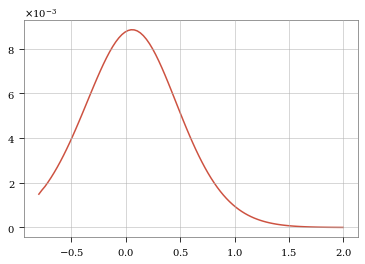

In [77]:
plt.plot(theta, prob_theta_given_data)

array([0.42609776])

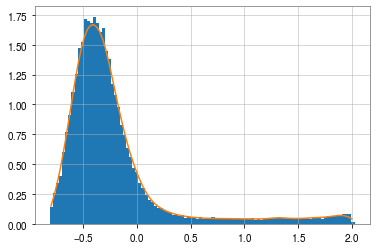

In [16]:
plt.hist(sampler.samples[param], density=True, bins=100)
plt.plot(point, kde.pdf(point))
kde.pdf(0)

In [ ]:
# old_prior = sampler.prior.copy()
# new_prior = sampler.prior.copy()
# new_prior["chirp_mass"] = bilby.gw.prior.UniformInComponentsChirpMass(minimum=15.0, maximum=50.0)
# new_prior["luminosity_distance"] = bilby.core.prior.LogUniform(minimum=25, maximum=1000)

# # Correcting Prior with prior ratio
# data = {k:np.array([val for val in v.values()], dtype=np.float64) for k, v in sampler.samples.to_dict().items()}
# old_prob = np.prod([old_prior[key].prob(data[key]) for key in data], axis=0)
# new_prob = np.prod([new_prior[key].prob(data[key]) for key in data], axis=0)
# weights = new_prob / old_prob
# print(weights[0], weights[1])
# weights = np.nan_to_num(weights)
# weights = weights / np.sum(weights)
# plt.hist(weights, bins=100)
# print(np.sum(weights))